In [1]:
# Install necessary libraries
!pip install torch
!pip install transformers
!pip install scikit-learn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
import torch

In [3]:
from google.colab import drive
drive.mount("GoogleDrive")

# Load data and Change this path Accordingly
df = pd.read_csv("GoogleDrive/MyDrive/SocialMediaTrendAnalysisDatasets/YoutubeTrends/USvideos.csv")

Mounted at GoogleDrive


In [4]:
print(df.columns)

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')


In [5]:
# Select relevant columns
# df = df[['trending_date', 'title', 'views', 'likes', 'comment_count']]
# Select relevant columns
df = df[['title', 'description', 'category_id', 'views', 'likes', 'dislikes', 'comment_count', 'trending_date']]
# Data Cleaning and Preprocessing
df['text'] = df['title'].fillna('') + ' ' + df['description'].fillna('')

# Define labels based on your criteria (e.g., if views are above a certain threshold)
threshold = 1000000
df['label'] = np.where(df['views'] > threshold, 1, 0)

In [6]:
# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [7]:
# RoBERTa Tokenizer and Model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Custom Dataset Class
class YouTubeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        title = str(self.data.title.iloc[index])
        inputs = self.tokenizer(
            title,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        inputs['label'] = torch.tensor(self.data.label.iloc[index], dtype=torch.long)
        return inputs

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 10

# Create DataLoader for training, validation, and test sets
train_dataset = YouTubeDataset(train_df, tokenizer, MAX_LEN)
val_dataset = YouTubeDataset(val_df, tokenizer, MAX_LEN)
test_dataset = YouTubeDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10: 100%|██████████| 1024/1024 [10:32<00:00,  1.62it/s]


Epoch 1/10, Average Loss: 0.4669496544811409


Validation: 100%|██████████| 128/128 [00:25<00:00,  5.01it/s]


Validation Loss: 0.3275316701619886
Validation Accuracy: 0.8691086691086691
Validation Precision: 0.7837837837837838
Validation Recall: 0.9262899262899262
Validation F1 Score: 0.8490990990990991


Epoch 2/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 2/10, Average Loss: 0.24431244477818836


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.99it/s]


Validation Loss: 0.23435897120361915
Validation Accuracy: 0.9250305250305251
Validation Precision: 0.9000605693519079
Validation Recall: 0.9127764127764127
Validation F1 Score: 0.9063738944800243


Epoch 3/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 3/10, Average Loss: 0.19686451903726265


Validation: 100%|██████████| 128/128 [00:25<00:00,  5.01it/s]


Validation Loss: 0.22675799706485122
Validation Accuracy: 0.9216117216117216
Validation Precision: 0.8519116855142703
Validation Recall: 0.9717444717444718
Validation F1 Score: 0.9078909612625538


Epoch 4/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 4/10, Average Loss: 0.17409016445162706


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.97it/s]


Validation Loss: 0.20411785822943784
Validation Accuracy: 0.9323565323565324
Validation Precision: 0.8827195467422096
Validation Recall: 0.957002457002457
Validation F1 Score: 0.9183613321544356


Epoch 5/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 5/10, Average Loss: 0.16119394196903158


Validation: 100%|██████████| 128/128 [00:25<00:00,  5.00it/s]


Validation Loss: 0.2007271409529494
Validation Accuracy: 0.9328449328449329
Validation Precision: 0.8811267605633802
Validation Recall: 0.9606879606879607
Validation F1 Score: 0.9191889509256539


Epoch 6/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 6/10, Average Loss: 0.15386077560742706


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.97it/s]


Validation Loss: 0.19443455878354143
Validation Accuracy: 0.9286935286935287
Validation Precision: 0.8686534216335541
Validation Recall: 0.9668304668304668
Validation F1 Score: 0.9151162790697674


Epoch 7/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 7/10, Average Loss: 0.14894484882825054


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.98it/s]


Validation Loss: 0.22000421640041168
Validation Accuracy: 0.9301587301587302
Validation Precision: 0.8765432098765432
Validation Recall: 0.9594594594594594
Validation F1 Score: 0.9161290322580644


Epoch 8/10: 100%|██████████| 1024/1024 [10:33<00:00,  1.62it/s]


Epoch 8/10, Average Loss: 0.1441417710739188


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.99it/s]


Validation Loss: 0.23247744349282584
Validation Accuracy: 0.9264957264957265
Validation Precision: 0.8600108518719479
Validation Recall: 0.9735872235872236
Validation F1 Score: 0.9132814750792279


Epoch 9/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.62it/s]


Epoch 9/10, Average Loss: 0.13922711546001665


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.99it/s]


Validation Loss: 0.23880559352983255
Validation Accuracy: 0.9299145299145299
Validation Precision: 0.8690148596587782
Validation Recall: 0.9699017199017199
Validation F1 Score: 0.9166908563134979


Epoch 10/10: 100%|██████████| 1024/1024 [10:34<00:00,  1.61it/s]


Epoch 10/10, Average Loss: 0.13522066321638704


Validation: 100%|██████████| 128/128 [00:25<00:00,  4.96it/s]


Validation Loss: 0.20100565128814196
Validation Accuracy: 0.9340659340659341
Validation Precision: 0.8897818599311137
Validation Recall: 0.952088452088452
Validation F1 Score: 0.9198813056379821


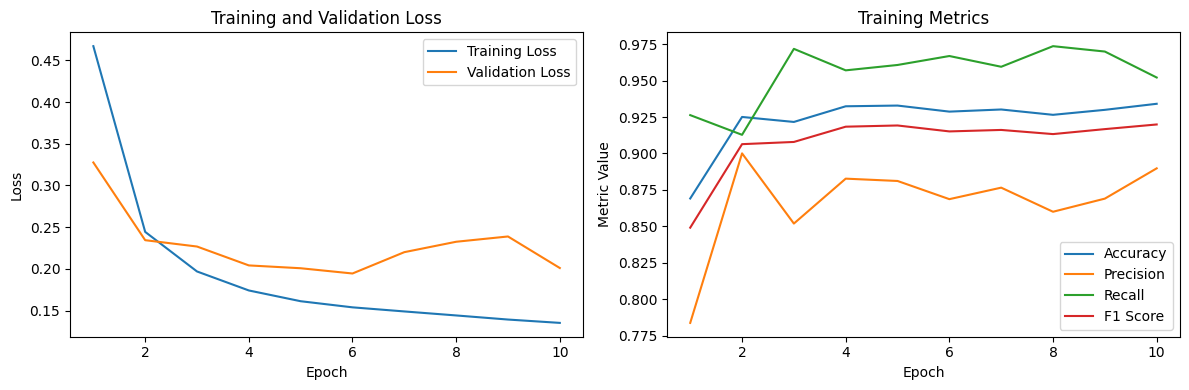

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Assuming you have defined EPOCHS, train_loader, val_loader, model, optimizer, loss_fn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        optimizer.zero_grad()

        # Move data to GPU
        inputs = {key: val.squeeze(1).to(device) for key, val in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Average Loss: {average_loss}")

    # Evaluation on the validation set
    model.eval()
    val_preds = []
    val_labels = []
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            inputs = {key: val.squeeze(1).to(device) for key, val in batch.items() if key != 'label'}
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            val_loss = loss_fn(logits, labels)
            total_val_loss += val_loss.item()

            val_preds.extend(torch.argmax(logits, 1).cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    # Metrics calculation
    accuracy = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Validation Loss: {average_val_loss}")
    print(f"Validation Accuracy: {accuracy}")
    print(f"Validation Precision: {precision}")
    print(f"Validation Recall: {recall}")
    print(f"Validation F1 Score: {f1}")

# Plotting the loss and metrics over epochs
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Metrics
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), accuracies, label='Accuracy')
plt.plot(range(1, EPOCHS + 1), precisions, label='Precision')
plt.plot(range(1, EPOCHS + 1), recalls, label='Recall')
plt.plot(range(1, EPOCHS + 1), f1_scores, label='F1 Score')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.tight_layout()
plt.show()


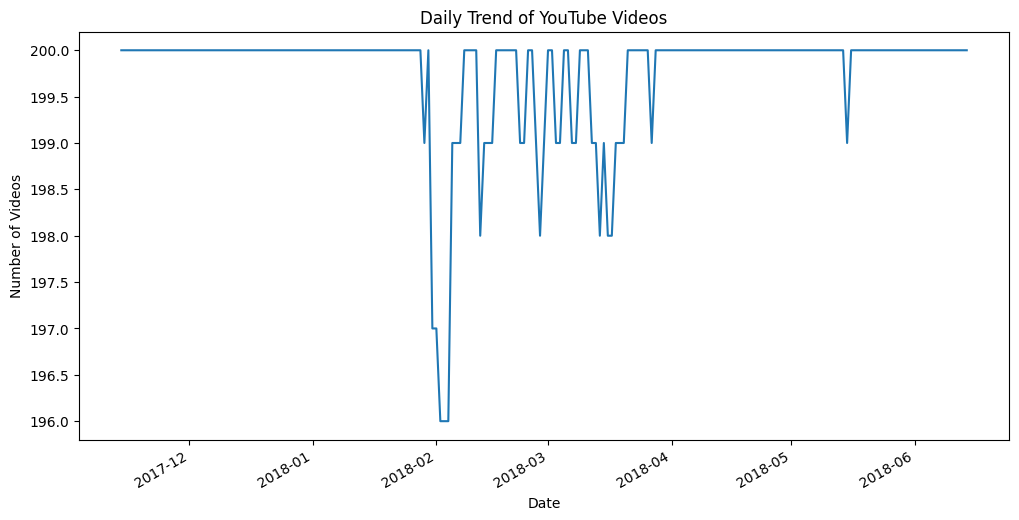

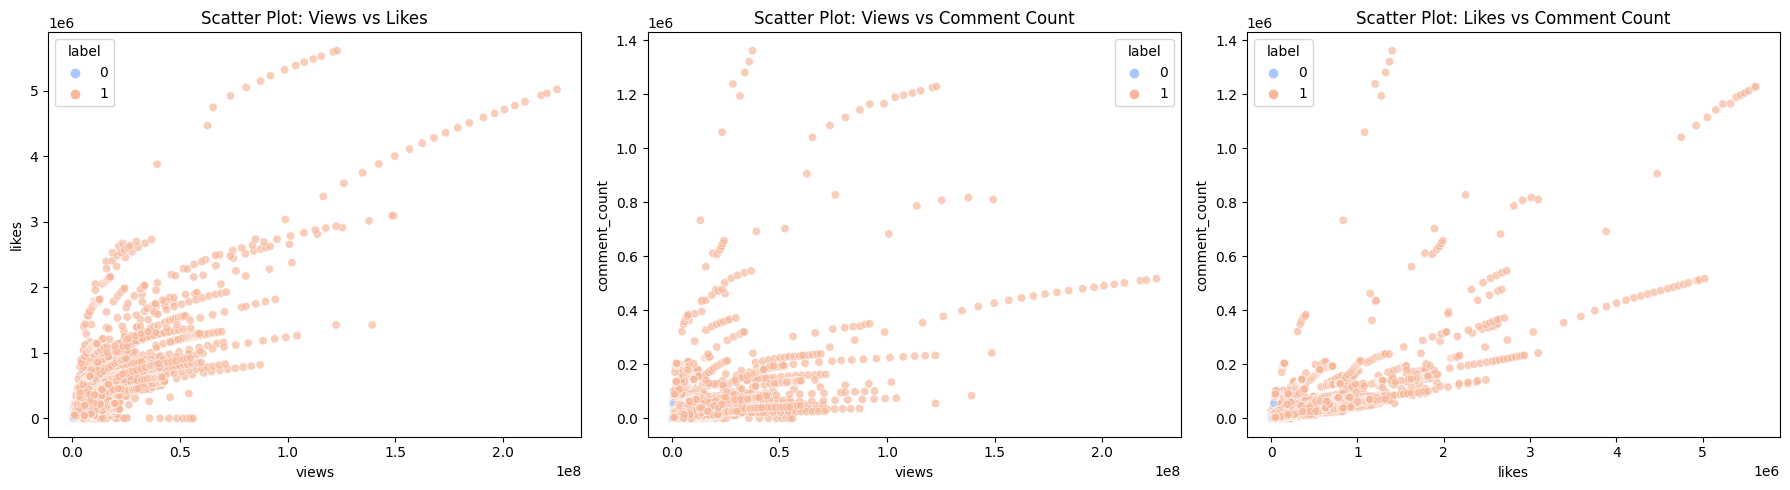

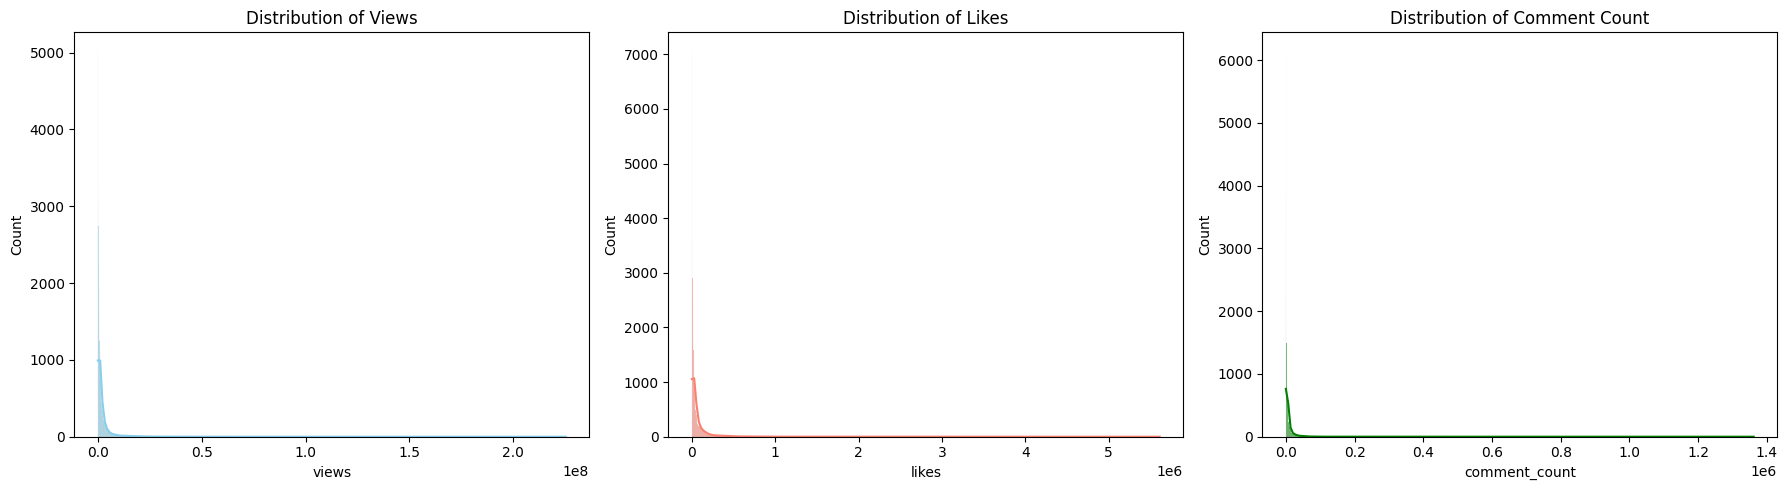

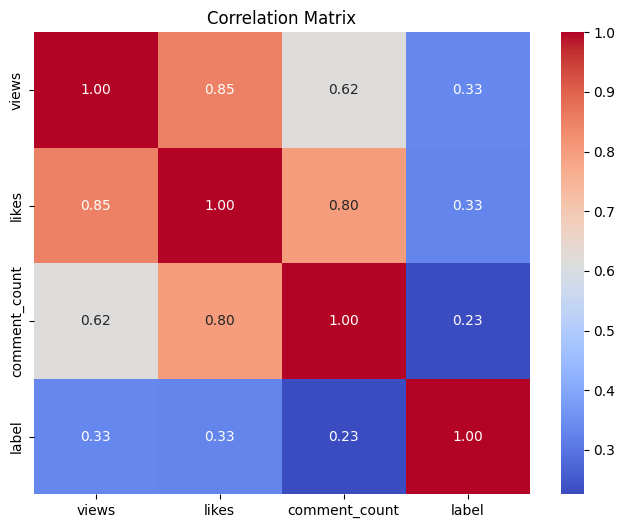

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Analyze trends based on trending_date
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
daily_trend = df.groupby('trending_date').size()

# Plotting daily trend
plt.figure(figsize=(12, 6))
daily_trend.plot(title='Daily Trend of YouTube Videos')
plt.xlabel('Date')
plt.ylabel('Number of Videos')
plt.show()

# 2. Analyze trends based on views, likes, and comment_count
# Scatter plots for views, likes, and comment_count
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='views', y='likes', data=df, hue='label', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot: Views vs Likes')

plt.subplot(1, 3, 2)
sns.scatterplot(x='views', y='comment_count', data=df, hue='label', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot: Views vs Comment Count')

plt.subplot(1, 3, 3)
sns.scatterplot(x='likes', y='comment_count', data=df, hue='label', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot: Likes vs Comment Count')

plt.tight_layout()
plt.show()

# 3. Analyze distribution of views, likes, and comment_count
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['views'], kde=True, color='skyblue')
plt.title('Distribution of Views')

plt.subplot(1, 3, 2)
sns.histplot(df['likes'], kde=True, color='salmon')
plt.title('Distribution of Likes')

plt.subplot(1, 3, 3)
sns.histplot(df['comment_count'], kde=True, color='green')
plt.title('Distribution of Comment Count')

plt.tight_layout()
plt.show()

# 4. Analyze correlation between features
correlation_matrix = df[['views', 'likes', 'comment_count', 'label']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
